Després de veure els resultats dels models sense features, ara toca experimentar amb quins features i quina codificació fan que el model millori.

In [1]:
import nltk
import re
import unicodedata
from nltk.tag import CRFTagger
nltk.download('conll2002')
nltk.download('stopwords')
from nltk.corpus import conll2002, stopwords

tr_sp = conll2002.iob_sents('esp.train') # Train Español
dev_sp = conll2002.iob_sents('esp.testa') # Dev Español
test_sp = conll2002.iob_sents('esp.testb') # Test Español

tr_ne = conll2002.iob_sents('ned.train') # Train Neerlandés
dev_ne = conll2002.iob_sents('ned.testa') # Dev Neerlandés
test_ne = conll2002.iob_sents('ned.testb') # Test Neerlandés

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
help(nltk.pos_tag)

Help on function pos_tag in module nltk.tag:

pos_tag(tokens, tagset=None, lang='eng')
    Use NLTK's currently recommended part of speech tagger to
    tag the given list of tokens.
    
        >>> from nltk.tag import pos_tag
        >>> from nltk.tokenize import word_tokenize
        >>> pos_tag(word_tokenize("John's big idea isn't all that bad.")) # doctest: +NORMALIZE_WHITESPACE
        [('John', 'NNP'), ("'s", 'POS'), ('big', 'JJ'), ('idea', 'NN'), ('is', 'VBZ'),
        ("n't", 'RB'), ('all', 'PDT'), ('that', 'DT'), ('bad', 'JJ'), ('.', '.')]
        >>> pos_tag(word_tokenize("John's big idea isn't all that bad."), tagset='universal') # doctest: +NORMALIZE_WHITESPACE
        [('John', 'NOUN'), ("'s", 'PRT'), ('big', 'ADJ'), ('idea', 'NOUN'), ('is', 'VERB'),
        ("n't", 'ADV'), ('all', 'DET'), ('that', 'DET'), ('bad', 'ADJ'), ('.', '.')]
    
    NB. Use `pos_tag_sents()` for efficient tagging of more than one sentence.
    
    :param tokens: Sequence of tokens to be tagged

In [3]:
# Transformar: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_sp]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_sp]
stop_words = set(stopwords.words('spanish'))

In [8]:

def features(tokens, idx):
        """
        Extract features about this word including
            - Current word
            - is it capitalized?
            - Does it have punctuation?
            - Does it have a number?
            - Suffixes up to length 3

        Note that : we might include feature over previous word, next word etc.

        :return: a list which contains the features
        :rtype: list(str)
        """
        

        pattern = re.compile(r"\d")

        token = tokens[idx]

        feature_list = []

        if not token:
            return feature_list
        
        # Capitalization (amb context)
        if token[0].isupper():
            if idx == 0:
                feature_list.append("CAPITALIZATION")
            """ elif tokens[idx - 1] in {".", "!", "?"}:
                feature_list.append("AFTER_PUNCT_CAPITALIZATION")
            else:
                feature_list.append("CAPITALIZATION") """
        
        """l = str(len(token))
        feature_list.append("LEN_"+ l)"""

        # Number
        if re.search(pattern, token) is not None:
            feature_list.append("HAS_NUM")

        # Punctuation
        punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
        if all(unicodedata.category(x) in punc_cat for x in token):
            feature_list.append("PUNCTUATION")
        """
        else:
            # POS TAG
            if token.lower() not in stop_words:
                try:
                    tag = nltk.pos_tag([token])[0][1]
                    feature_list.append("POS_TAG_" + tag)
                except Exception:
                    feature_list.append("POS_TAG_UNK")
            else:
                feature_list.append("STOP_WORD")
        """

        #Prefixos i sufixos típics de organitzacions i localitzacions
        """
        org_suffixes = ["ción", "dad", "mento", "ario", "tech", "bank", "corp", "logía", "al"]
        loc_suffixes = ["ia", "ana", "ila", "ón", "co", "gua", "os", "al", "or", "el"]

        # Per cada token:
        for suf in org_suffixes:
            if token.lower().endswith(suf):
                feature_list.append("ORG_SUFFIX_" + suf.upper())

        for suf in loc_suffixes:
            if token.lower().endswith(suf):
                feature_list.append("LOC_SUFFIX_" + suf.upper())
        """
        
        # Suffix up to length 4
        if len(token) > 1:
            feature_list.append("SUF_" + token[-1:])
        if len(token) > 2:
            feature_list.append("SUF_" + token[-2:])
        if len(token) > 3:
            feature_list.append("SUF_" + token[-3:])
        if len(token) > 4:
            feature_list.append("SUF_" + token[-4:])
                

        # Prefixes up to length 4
        if len(token) > 1:
            feature_list.append("PREF_" + token[:1])
        if len(token) > 2:
            feature_list.append("PREF_" + token[:2])
        if len(token) > 3:
            feature_list.append("PREF_" + token[:3])
        if len(token) > 4:
            feature_list.append("PREF_" + token[:4])

        if idx > 0:
            prev_token = tokens[idx - 1]
            feature_list.append("PREV_WORD_" + prev_token)
        else:
            feature_list.append("BOS")  # Beginning of sentence

        # Next word
        if idx < len(tokens) - 1:
            next_token = tokens[idx + 1]
            feature_list.append("NEXT_WORD_" + next_token)
        else:
            feature_list.append("EOS")  # End of sentence

        

        #Codi per implementar dos tokens anteriors y dos posteriors (té pitjor rendiment que un token)
        """ if idx > 1:
            prev_token = tokens[idx - 1]
            ant_prev_token = tokens[idx - 2]
            feature_list.append("PREV_WORD_" + prev_token + "_" + ant_prev_token)
        elif idx > 0:
            prev_token = tokens[idx - 1]
            feature_list.append("PREV_WORD_" + prev_token)
        else:
            feature_list.append("BOS")  # Beginning of sentence
        
        
        
        if idx < len(tokens) - 2:
            next_token = tokens[idx + 1]
            post_next_token = tokens[idx + 2]
            feature_list.append("NEXT_WORD_" + next_token +"_"+post_next_token)
        elif idx < len(tokens) - 1:
            next_token = tokens[idx + 1]
            feature_list.append("NEXT_WORD_" + next_token)
        else:
            feature_list.append("EOS")  # End of sentence
        """

        feature_list.append("WORD_" + token)

        return feature_list


"""
Codi base extret https://www.nltk.org/_modules/nltk/tag/crf.html <- Ampliem els features que venen de base a nltk.tag.CRFTagger()

Features afegits: 
    · Prefixos de fins a longitud 4, també extenem els sufixos de fins longitud 4
    · 1 Token anterior i un posterior
    · Diferenciació entre Capitalització a principi de frase o després de signe de puntuació 
    · POS TAGS <- El model triga molt més i les prediccions tmb. 
    · ...
"""

'\nCodi base extret https://www.nltk.org/_modules/nltk/tag/crf.html <- Ampliem els features que venen de base a nltk.tag.CRFTagger()\n\nFeatures afegits: \n    · Prefixos de fins a longitud 4, també extenem els sufixos de fins longitud 4\n    · 1 Token anterior i un posterior\n    · Diferenciació entre Capitalització a principi de frase o després de signe de puntuació \n    · POS TAGS <- El model triga molt més i les prediccions tmb. \n    · ...\n'

In [9]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'esp_model.crf.tagger')
ct.set_model_file('esp_model.crf.tagger')

In [10]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])

In [ ]:
#Accuracy a nivell de entitats, nms ens interesa saber si troba be les entitats, no totes les paraules
true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Calcular accuracy solo sobre entidades
correct = sum(t1 == t2 for t1, t2 in zip(true_entities, predicted_entities))
total = len(true_entities)
accuracy = correct / total if total > 0 else 0.0

print(f"Exactitud sobre entidades: {accuracy:.2%}")
print(f"Entidades no reconocidas por el modelo: {sum(i =='O' for i in true_entities)}")
print(f"Errores del modelo: {total - correct}")
print(total, sum([len(i) for i in predicted_sents]))


Exactitud sobre entidades: 76.05%
Entidades no reconocidas por el modelo: 193
Errores del modelo: 1526
6371 51533


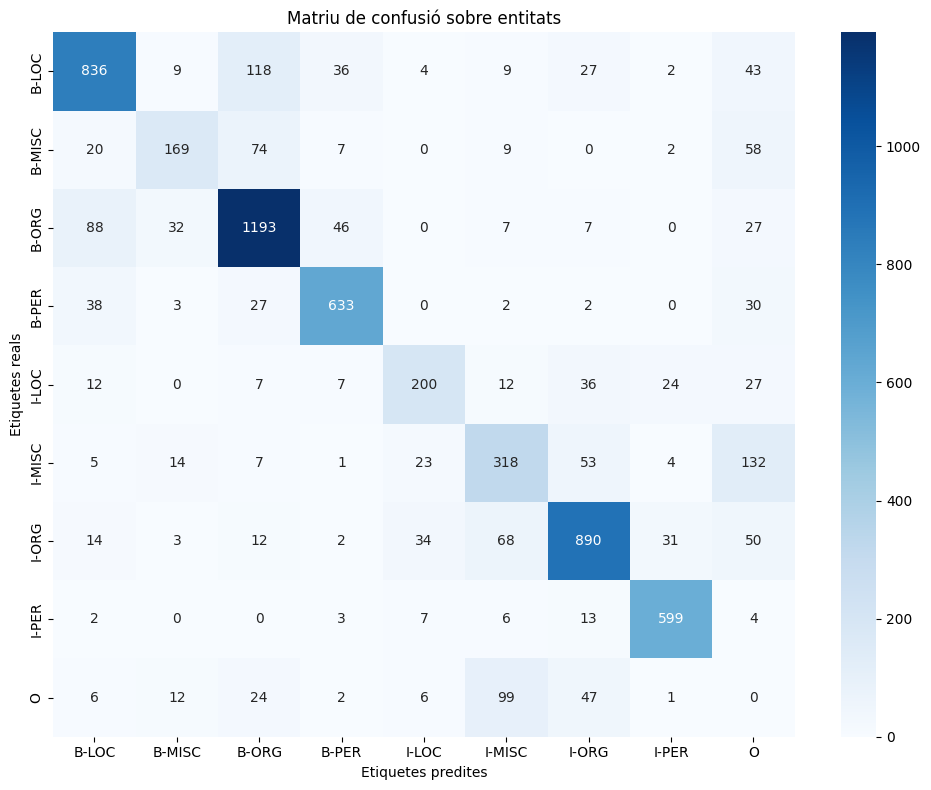

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

resultats = []
for i, label in enumerate(labels):
    correctes = cm[i, i]
    prediccions_totals = sum(cm[:, i])  # total de vegades que es va predir aquesta etiqueta
    errors = prediccions_totals - correctes
    percentatge = (correctes / prediccions_totals * 100) if prediccions_totals > 0 else 0.0
    resultats.append({
        'Etiqueta': label,
        'Correctes': correctes,
        'Errors': errors,
        '% d\'encerts': f"{percentatge:.2f}%"
    })

df_resultats = pd.DataFrame(resultats)
print(df_resultats)

  Etiqueta  Correctes  Errors % d'encerts
0    B-LOC        836     193      81.24%
1   B-MISC        169      73      69.83%
2    B-ORG       1194     274      81.34%
3    B-PER        642     104      86.06%
4    I-LOC        207      78      72.63%
5   I-MISC        314     189      62.43%
6    I-ORG        898     186      82.84%
7    I-PER        598      65      90.20%
8        O          0     357       0.00%
